# Spiking Motif Sorting
## A first step with a mixture of motifs and dimensionality reduction

Different motifs linearly overlap in a raster plot and we treat here the cocktail party problem where results can be two fold: 
- be able to differentiate the different sources
- be able to retrieve the spiking motifs/patterns associated to the different sources

## Model with 3 motifs and a linear combination of the 3

In the case with 3 motifs, NMF is still the only method that is able to estimate efficiently the different sources. Other methods can find interesting manifolds to reduce the dimension of the input and describe it in terms of 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from untitled import SM_World, plot_SM, plot_raster, make_input_and_plot_sdist, plot_embedding, plot_3d_embedding, plot_corrcoef
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap

/Users/antoux/Library/Python/3.9/lib/python/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/antoux/Documents/SpikeShip/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [3]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 0.1 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 0.05 # variance for the precision

    seed = 4815162342 # seed

## Model with 2 motifs and a linear combination of the 2

Each kernel represents a spiking pattern that will repeat in the raster plot with more or less temporal precision. To simulate the temporal jitter associated to the different spikes of the motif, a gaussian kernel, specific to each spike (this specificity depends on *std_precision*), is used to convolve the all-or-none events (the precision is given by the standard deviation of the gaussian kernel). The mixture of the 2 kernels (here kernel #3) is given with a linear combination of the kernels with coefficients between 0 and 1. They can be normalized (sum=1) or not. 

To draw the input raster plot, we use the different kernels and a bernoulli trial that will give on raster plot for one trial. Such a raster plot (for on trial) corresponds to the time window of the kernel (prior on the detection of the motifs) and motifs can overlap only with 0 time lag. 

In [4]:
opt = world_params()
add_coef = torch.rand([opt.N_kernels])
print(add_coef)
world = SM_World(opt, add_coef = add_coef/add_coef.sum())
input_rp, labels = world.draw_input_one_sm()

tensor([0.8031, 0.0223, 0.2620])


/Users/antoux/Documents/sms/2023-09-15_dimensionality_reduction/untitled.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T


In [5]:
#matplotlib.colormaps['Purples']
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
def plot_SM(SMs, N_show = 5, cmap='Purples', colors=None, aspect=None, figsize = (12, 1.61803)):
    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)
    plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica"
    })

    N_SMs, N_pre, N_delays = SMs.shape
    steps_pre = N_pre/10

    fig, axs = plt.subplots(1, N_show, figsize=figsize, subplotpars=subplotpars)
    for i_SM in range(N_show):
        ax = axs[i_SM]
        ax.set_axisbelow(True)
        ax.pcolormesh(SMs[i_SM, :, :].flip(1), cmap=cmap, vmin=SMs.min(), vmax=SMs.max())
        #ax.imshow(self.SMs[:, i_SM, :], cmap=cmap, vmin=0, vmax=1, interpolation='none')
        ax.set_xlim(0, N_delays)
        ax.set_xlabel('Delay')
        if i_SM+1<N_show:
            t = ax.text(.805*N_delays, .95*N_pre, f'$K_{i_SM+1}$', color='k' if colors is None else colors[i_SM])
        else:
            t = ax.text(.65*N_delays, .95*N_pre, "$\sum_i c_i.K_i$", color='k' if colors is None else colors[i_SM])
        t.set_bbox(dict(facecolor='white', edgecolor='white'))
        if not aspect is None: ax.set_aspect(aspect)

        ax.set_ylim(0, N_pre)
        ax.set_yticks(np.arange(0, N_pre, steps_pre)+.5)
        if i_SM>0:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(np.arange(0, N_pre, steps_pre)+1)

        for side in ['top', 'right']: ax.spines[side].set_visible(False)
        ax.set_xticks([1, N_delays//3, (N_delays*2)//3])
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(N_delays//4))

    axs[0].set_ylabel('@ Neuron')
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axs[:], orientation='vertical', ticks=[0, 1],
                    format=matplotlib.ticker.FixedFormatter(np.round([SMs.min().item(), SMs.max().item()],3)))
    #cbar.set_ticks([0,1]);
    #cbar.ax.set_xticklabels(SMs.min(), SMs.max());
    return fig, axs

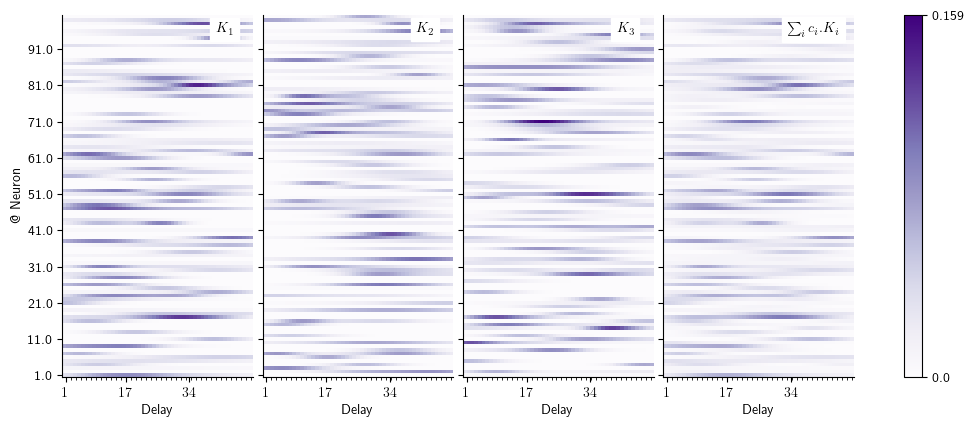

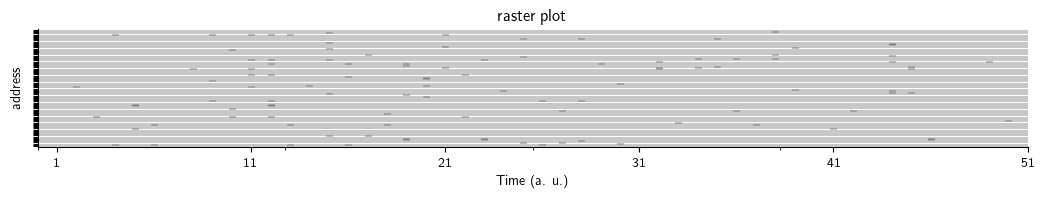

In [6]:
fig, ax = plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
fig.savefig('dim_reduction.pdf')
plot_raster(input_rp, colored=False);

## Format the ouput for SpikeShip and compute the dissimilarity matrix

Here, data is drawn, the total number of trials is given by $N_{trials}*N_{coef-changes}$ where $N_{coef-changes}$ represents the number of time a new set of linear combination coefficient are randomly selected. If *mixture_only* is *True*, only the last kernel (mixture of patterns) is used to make the raster plots. 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5010/5010 [02:29<00:00, 33.41it/s]


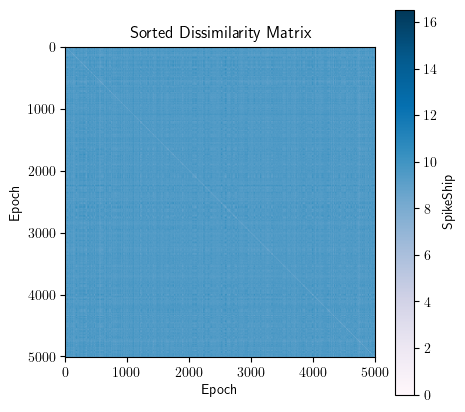

In [7]:
N_trials = 10
N_coef_changes = 500
normalize_coef = True
mixture_only = True
plot = True # to plot the dissimilarity matrix given by SpikeShip
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef, mixture_only=mixture_only, plot=plot)

Here we choose not to give the original patterns but just a lot of different mixtures and how we can retrieve the different components (original patterns).

## Linear dimensionality reduction technique - Decomposition into different components
### PCA decomposition (more results can be found in [PCA notebook](2023-10-04_PCA.ipynb))

In [8]:
number_of_components=opt.N_kernels#-normalize_coef
print(f'Expected number of components {number_of_components}')

Expected number of components 3


CPU times: user 2.11 s, sys: 153 ms, total: 2.27 s
Wall time: 1.22 s


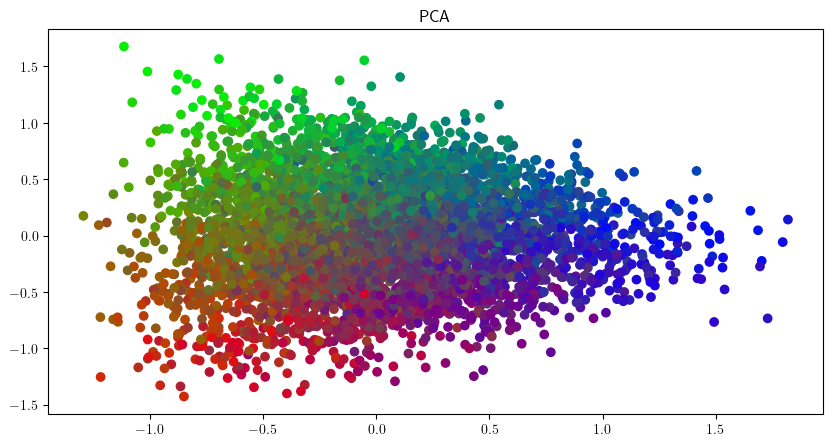

In [9]:
%%time
input_flatten = input_rp.flatten(start_dim=1)
pca = PCA(n_components=number_of_components)
plot_embedding(pca.fit_transform(input_flatten), labels, 'PCA')

### Non-negative matrix factorization (more results can be found in [NMF notebook](2023-10-04_NMF.ipynb))

CPU times: user 14.1 s, sys: 533 ms, total: 14.7 s
Wall time: 8.22 s


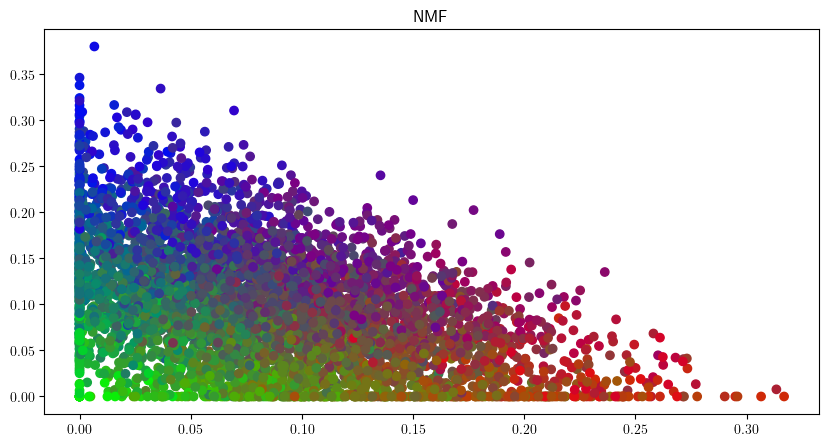

In [10]:
%%time
nmf = NMF(n_components=number_of_components)
plot_embedding(nmf.fit_transform(input_flatten), labels, 'NMF')

### Trying to retrieve the different components (motifs)
#### For PCA

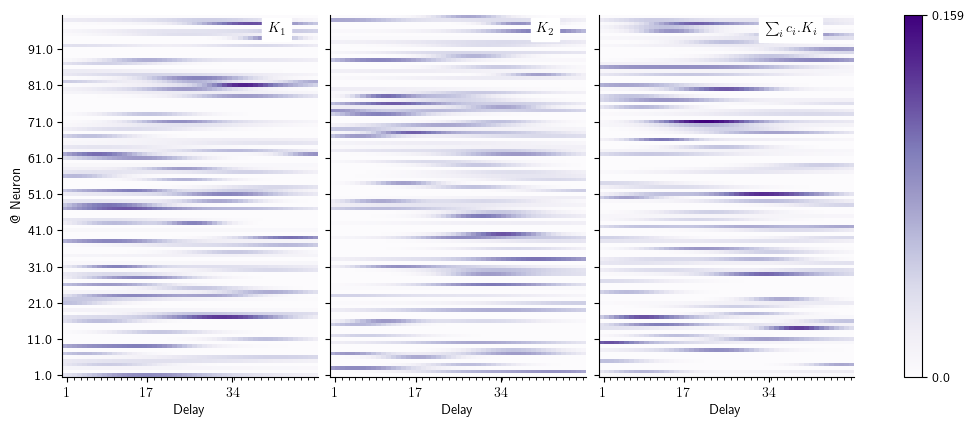

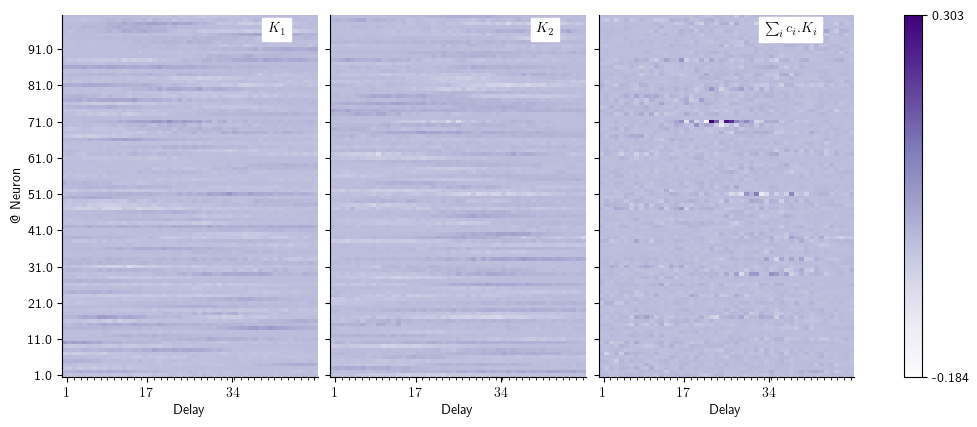

In [11]:
pca.fit(input_flatten)
estimated_kernels = pca.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

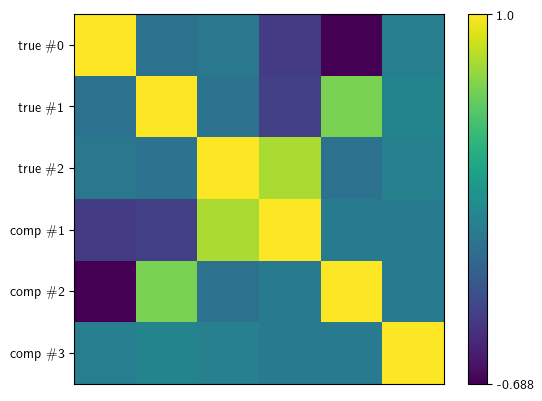

In [12]:
plot_corrcoef(world, estimated_sms)

#### For NMF

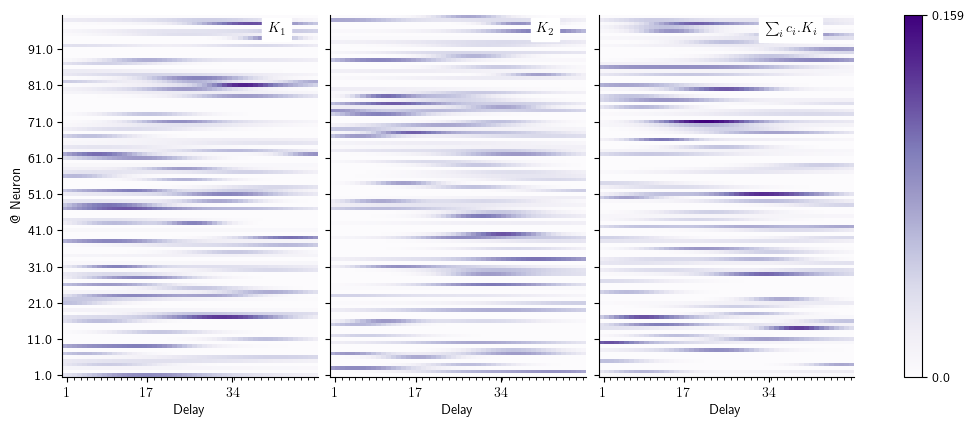

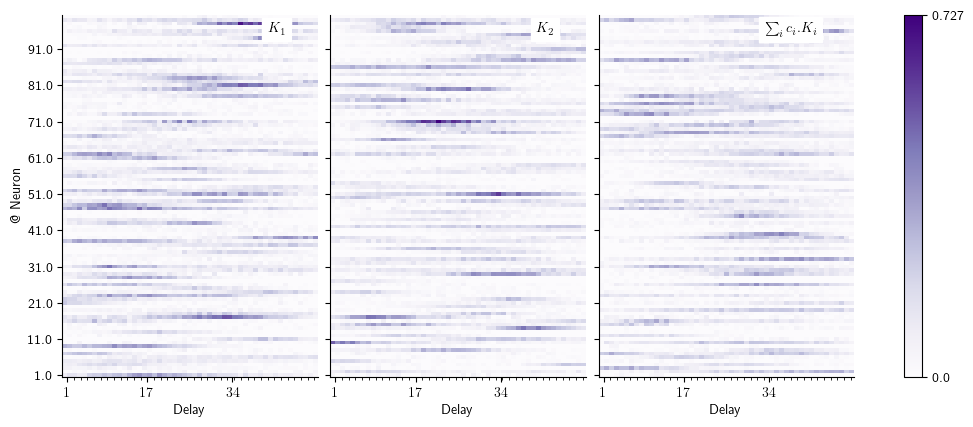

In [13]:
nmf.fit(input_flatten)
estimated_kernels = nmf.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

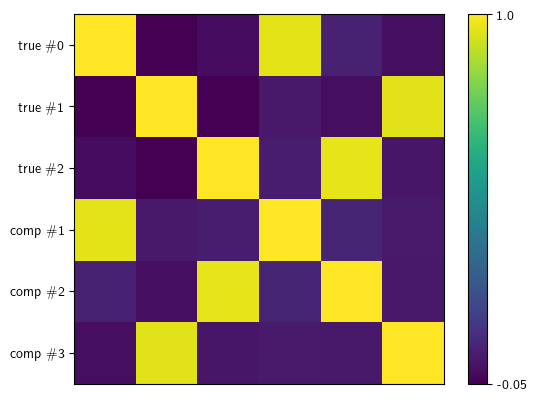

In [14]:
plot_corrcoef(world, estimated_sms)

## Manifold learning
Because SpikeShip is a non-Euclidian metric, results obtained using the dissimilarity matrix can be different and present a manifold learning that is not limited by linear dimensionality reduction. 

### With PCA on SpikeShip dissimilarity matrix

In [15]:
pca = PCA(n_components=number_of_components)
pca.fit(S_dist)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)

PCA(n_components=3)

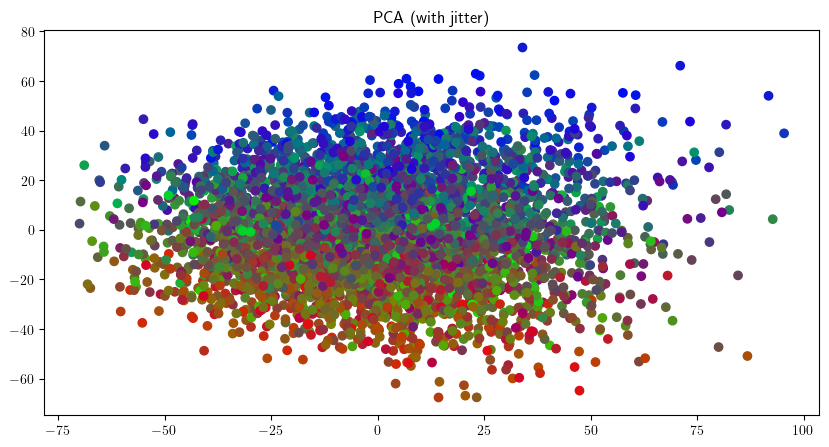

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(pca.fit_transform(S_dist)[indices,0], pca.fit_transform(S_dist)[indices,1], facecolors=colors[int(l)])#, label=f'{np.round(l*100)}%')
    else:
        ax.scatter(pca.fit_transform(S_dist)[indices,0], pca.fit_transform(S_dist)[indices,1], facecolors=labels[indices,:3])
#ax.legend(loc='upper right')
ax.set_title('PCA (with jitter)');

### Multidimensional scaling [(guide)](https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/)
#### With SpikeShip dissimilarity matrix

In [17]:
%%time
mds = MDS(n_components=number_of_components, dissimilarity='precomputed', normalized_stress='warn')
embedding = mds.fit_transform(S_dist)
plot_embedding(embedding, labels, 'MDS')
#mds.stress_

InvalidParameterError: The 'normalized_stress' parameter of MDS must be an instance of 'bool' or an instance of 'numpy.bool_' or a str among {'auto'}. Got 'warn' instead.

In [18]:
if number_of_components>2:
    view_init = [0,90]
    plot_3d_embedding(embedding, labels, 'MDS', view_init=view_init)
    view_init = [0,0]
    plot_3d_embedding(embedding, labels, 'MDS', view_init=view_init)
    view_init = [60,60]
    plot_3d_embedding(embedding, labels, 'MDS', view_init=view_init)

NameError: name 'embedding' is not defined

#### With euclidian distance on the raster plots

In [ ]:
%%time
mds_euclidian = MDS(n_components=number_of_components, dissimilarity='euclidean', normalized_stress='warn')
embedding = mds_euclidian.fit_transform(input_flatten)
plot_embedding(embedding, labels, 'MDS')
mds_euclidian.stress_

### Isomap

CPU times: user 2min 2s, sys: 3.24 s, total: 2min 6s
Wall time: 2min 4s


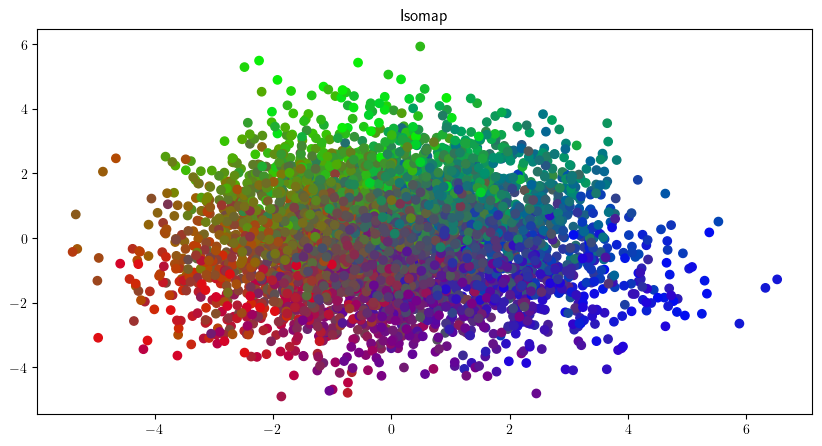

In [19]:
%%time
isomap = Isomap(n_components=number_of_components, metric='precomputed', n_neighbors=S_dist.shape[0]-1).fit_transform(S_dist)
plot_embedding(isomap, labels, 'Isomap')

### Laplacian eigenmaps

In [ ]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, affinity='precomputed').fit_transform(S_dist)
plot_embedding(s_embedding, labels, 'Laplacian Eigenmaps')

In [ ]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, n_neighbors=50, affinity='precomputed_nearest_neighbors').fit_transform(S_dist)
plot_embedding(s_embedding, labels, 'Laplacian Eigenmaps')

In [ ]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, n_neighbors=20, affinity='rbf').fit_transform(input_flatten)
plot_embedding(s_embedding, labels, 'Laplacian Eigenmaps')

The laplacian eigenmaps method does not seem to solve the problem when using SpikeShip as the precomputed metric. 

### t-SNE

In [ ]:
%%time
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, random_state=0, init='random').fit_transform(S_dist)
plot_embedding(tsne_embedding, labels, 't-SNE')

In [ ]:
if number_of_components>2:
    view_init = [0,90]
    plot_3d_embedding(tsne_embedding, labels, 't-SNE', view_init=view_init)
    view_init = [0,0]
    plot_3d_embedding(tsne_embedding, labels, 't-SNE', view_init=view_init)
    view_init = [60,60]
    plot_3d_embedding(tsne_embedding, labels, 't-SNE', view_init=view_init)